# Train and evaluate DFR on ImageNet-9 variations

In [42]:
import sys
import numpy as np
import torch
import torchvision
import einops
import json
import tqdm

from matplotlib import pyplot as plt

import sys
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [43]:
device = torch.device("cuda:7")

learning_rate = 1
num_epochs = 1000

ns = [5000, 10000, 20000, 45405]
num_seeds = 5

In [44]:
map_to_in9 = {}
with open('in_to_in9.json', 'r') as f:
    map_to_in9.update(json.load(f))

def load_embeddings(path):
    arr = np.load(path)
    x, y = arr["embeddings"], arr["labels"]
    if np.max(y) > 9:
        y = np.array([map_to_in9[str(y_)] for y_ in y])
        mask = y != -1
        x, y = x[mask], y[mask]
    return x, y

In [45]:
def train_logreg(
    x_train, y_train, eval_datasets,
    n_epochs=1000, weight_decay=0., lr=1.,
    verbose=0
    ):
    
    x_train = torch.from_numpy(x_train).float().to(device)
    y_train = torch.from_numpy(y_train).long().to(device)
    
    d = x_train.shape[1]
    model = torch.nn.Linear(d, 9).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(), weight_decay=weight_decay, lr=lr)
    schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        pred = model(x_train)
        loss = criterion(pred, y_train)
        loss.backward()
        optimizer.step()
        schedule.step()
        acc = (torch.argmax(pred, -1) == y_train).detach().float().mean()
        if verbose > 1 and epoch % (n_epochs // 10) == 0:
            print(epoch, acc)
    
    results = {}
    for key, (x_test, y_test) in eval_datasets.items():
        x_test = torch.from_numpy(x_test).float().to(device)
        pred = torch.argmax(model(x_test), axis=-1).detach().cpu().numpy()
        results[key] = (pred == y_test).mean()
    
    pred = torch.argmax(model(x_train), axis=-1)
    results["train"] = (pred == y_train).detach().cpu().float().mean().item()

    return model, results

def get_data(
    train_datasets, eval_datasets, 
    num_mixrand=-1, num_original=0, preprocess=True):
    
    x_train, y_train = train_datasets["bgc_original"]
    idx = np.arange(len(x_train))
    np.random.shuffle(idx)
    idx = idx[:num_original]
    x_train = x_train[idx]
    y_train = y_train[idx]

    x_train_mr, y_train_mr = train_datasets["bgc_mixedrand"]
    idx = np.arange(len(x_train_mr))
    np.random.shuffle(idx)
    idx = idx[:num_mixrand]
    x_train_mr = x_train_mr[idx]
    y_train_mr = y_train_mr[idx]

    x_train = np.concatenate([x_train, x_train_mr])
    y_train = np.concatenate([y_train, y_train_mr])

    if preprocess:
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        eval_datasets_preprocessed = {
            k: (scaler.transform(x), y)
            for k, (x, y) in eval_datasets.items()
        }
    else:
        eval_datasets_preprocessed = eval_datasets
    return x_train, y_train, eval_datasets_preprocessed


def run_experiment(
    train_datasets, eval_datasets,
    num_mixrand=-1, num_original=0, preprocess=True,
    n_epochs=1000, weight_decay=0., lr=1., verbose=0,
    num_seeds=3
):
    print(lr)
    print(weight_decay)
    print(n_epochs)
    results = {}
    for seed in range(num_seeds):
        x_train, y_train, eval_datasets_preprocessed = get_data(
            train_datasets, eval_datasets,
            num_mixrand, num_original, preprocess)
        _, results_seed = train_logreg(
            x_train, y_train, eval_datasets_preprocessed,
            n_epochs, weight_decay, lr, verbose)
        results[seed] = results_seed
    
    results_aggrgated = {
        key: (np.mean([results[seed][key] for seed in results.keys()]),
              np.std([results[seed][key] for seed in results.keys()]))
        for key in results[0].keys()
    }
    return results, results_aggrgated


def print_results(results_dict):
    print("-------------------")
    for key, val in results_dict.items():
        print("{}: {:.3f}±{:.3f}".format(key, val[0], val[1]))
    print("-------------------")

In [46]:
def mixrand_run(ns, n_epochs, lr, train_datasets, eval_datasets, num_seeds):
    mixrand_results_ns = []
    for n in ns:
        num_mixrand = n
        num_original = 0

        n_data = num_mixrand + num_original
        wd = 100 / n_data
        seed_results, results_aggrgated = run_experiment(
            train_datasets, eval_datasets,
            num_mixrand, num_original, lr=lr, weight_decay=wd, n_epochs=n_epochs,
            num_seeds=num_seeds)
        print_results(results_aggrgated)
        mixrand_results_ns.append(results_aggrgated)
    return mixrand_results_ns


def combo_run(ns, n_epochs, lr, train_datasets, eval_datasets, num_seeds):
    combo_results_ns = []
    for n in ns:
        num_mixrand = n
        num_original = n

        n_data = num_mixrand + num_original
        wd = 100 / n_data
        seed_results, results_aggrgated = run_experiment(
            train_datasets, eval_datasets,
            num_mixrand, num_original, lr=lr, weight_decay=wd, n_epochs=n_epochs,
            num_seeds=num_seeds)
        print_results(results_aggrgated)
        combo_results_ns.append(results_aggrgated)
    return combo_results_ns

In [47]:
def plot_results_indv(key, ax, ns, mixrand_results_ns, combo_results_ns, results_original):
    mixrand_mu = np.array([results[key][0] for results in mixrand_results_ns])
    mixrand_sigma = np.array([results[key][1] for results in mixrand_results_ns])

    original_mu = np.array([results_original[key][0] for _ in ns])
    original_sigma = np.array([results_original[key][1] for _ in ns])

    combo_mu = np.array([results[key][0] for results in combo_results_ns])
    combo_sigma = np.array([results[key][1] for results in combo_results_ns])
    ax.plot(ns, mixrand_mu, "-bo", label="DFR MR")
    ax.fill_between(ns, mixrand_mu + mixrand_sigma, mixrand_mu - mixrand_sigma,
                   color="b", alpha=0.3)
    ax.plot(ns, combo_mu, "-ro", label="DFR MR + Og")
    ax.fill_between(ns, combo_mu + combo_sigma, combo_mu - combo_sigma,
                    color="r", alpha=0.3)
    ax.plot(ns, original_mu, "--g", label="DFR Og")
    ax.fill_between(ns, original_mu + original_sigma, original_mu - original_sigma,
                    color="g", alpha=0.3)
    
    ax.legend()
    ax.set_xlabel("# MixedRand Data", fontsize=12)
    ax.set_ylabel(f"{key} Test Acc", fontsize=12)

def plot_all_results_indv(mixrand_results_ns, combo_results_ns, results_original):
    f, arr = plt.subplots(1, 5, figsize=(16, 3))

    plot_results_indv("bgc_mixedrand", arr[0], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
    plot_results_indv("bgc_fg", arr[1], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
    plot_results_indv("bgc_original", arr[2], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
    plot_results_indv("imagenet_r", arr[3], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
    plot_results_indv("imagenet_a", arr[4], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)

    plt.tight_layout()

## Original Network

In [48]:
use_prev_layer = False

eval_path_dict = {
    "imagenet_r": f"/home/data/imagenet-r/imagenet-r_{use_prev_layer}_val_embeddings.npz",
    "imagenet_a": f"/home/data/imagenet-a/imagenet-a_{use_prev_layer}_val_embeddings.npz",
    "bgc_original": f"/home/data/bg_challenge/original/bg_challenge_{use_prev_layer}_val_embeddings.npz",
    "bgc_fg": f"/home/data/bg_challenge/only_fg/bg_challenge_{use_prev_layer}_val_embeddings.npz",
    "bgc_mixedrand": f"/home/data/bg_challenge/mixed_rand/bg_challenge_{use_prev_layer}_val_embeddings.npz",
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    "bgc_original": f"/home/data/original/bg_challenge_{use_prev_layer}_train_embeddings.npz",
    "bgc_mixedrand": f"/home/data/mixed_rand/bg_challenge_{use_prev_layer}_train_embeddings.npz",

}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [49]:
_, results_original_ori = run_experiment(train_datasets, eval_datasets,
                                                num_mixrand=0, num_original=-1, lr=learning_rate, num_seeds=num_seeds, n_epochs=num_epochs,
                                                weight_decay=100/45405)

print_results(results_original_ori)

1
0.0022024006166721727
1000
-------------------
imagenet_r: 0.547±0.000
imagenet_a: 0.376±0.001
bgc_original: 0.978±0.000
bgc_fg: 0.924±0.001
bgc_mixedrand: 0.859±0.001
train: 0.997±0.000
-------------------


In [50]:
mixrand_results_ns_ori = mixrand_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)
combo_results_ns_ori = combo_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)

1
0.02
1000
-------------------
imagenet_r: 0.524±0.016
imagenet_a: 0.281±0.018
bgc_original: 0.950±0.004
bgc_fg: 0.923±0.003
bgc_mixedrand: 0.896±0.002
train: 0.980±0.002
-------------------
1
0.01
1000
-------------------
imagenet_r: 0.536±0.008
imagenet_a: 0.283±0.011
bgc_original: 0.953±0.001
bgc_fg: 0.924±0.005
bgc_mixedrand: 0.908±0.002
train: 0.956±0.001
-------------------
1
0.005
1000
-------------------
imagenet_r: 0.532±0.005
imagenet_a: 0.287±0.008
bgc_original: 0.958±0.001
bgc_fg: 0.930±0.003
bgc_mixedrand: 0.920±0.001
train: 0.937±0.001
-------------------
1
0.0022024006166721727
1000
-------------------
imagenet_r: 0.556±0.000
imagenet_a: 0.286±0.000
bgc_original: 0.963±0.000
bgc_fg: 0.938±0.000
bgc_mixedrand: 0.926±0.000
train: 0.915±0.000
-------------------
1
0.01
1000
-------------------
imagenet_r: 0.520±0.005
imagenet_a: 0.313±0.009
bgc_original: 0.967±0.002
bgc_fg: 0.926±0.005
bgc_mixedrand: 0.902±0.003
train: 0.981±0.001
-------------------
1
0.005
1000
---------

In [51]:
print(results_original_ori)

{'imagenet_r': (0.547419333465845, 0.0004520962594376806), 'imagenet_a': (0.3764011799410029, 0.0011577920699878189), 'bgc_original': (0.9784691358024691, 0.00018477320428514463), 'bgc_fg': (0.9242962962962963, 0.0009185716166784407), 'bgc_mixedrand': (0.8594567901234568, 0.0006698597514197891), 'train': (0.9972821712493897, 2.2464755770102768e-05)}


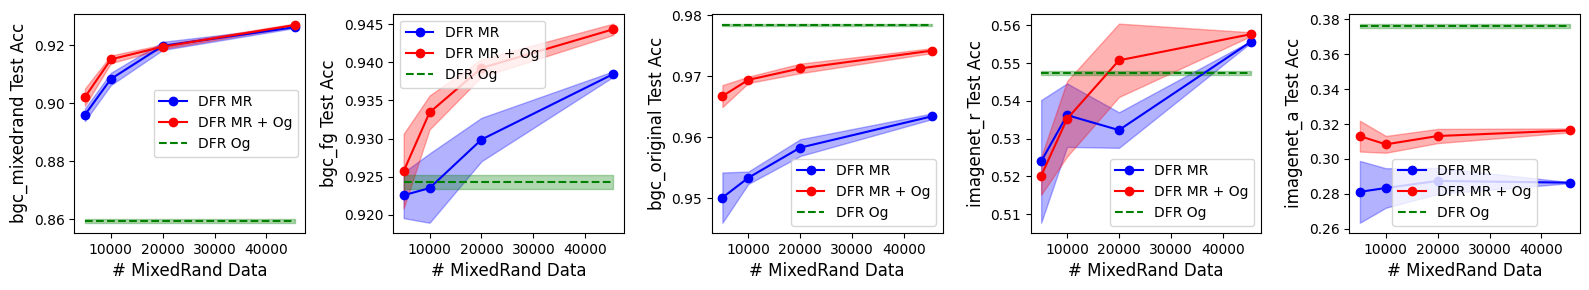

In [52]:
plot_all_results_indv(mixrand_results_ns_ori, combo_results_ns_ori, results_original_ori)

## No Projection

In [53]:
use_prev_layer = False

eval_path_dict = {
    "imagenet_r": f"/home/data/imagenet-r/29_imagenet-r_{use_prev_layer}_val_standardSL_embeddings.npz",
    "imagenet_a": f"/home/data/imagenet-a/29_imagenet-a_{use_prev_layer}_val_standardSL_embeddings.npz",
    "bgc_original": f"/home/data/bg_challenge/original/29_bg_challenge_{use_prev_layer}_val_standardSL_embeddings.npz",
    "bgc_fg": f"/home/data/bg_challenge/only_fg/29_bg_challenge_{use_prev_layer}_val_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/data/bg_challenge/mixed_rand/29_bg_challenge_{use_prev_layer}_val_standardSL_embeddings.npz",
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    "bgc_original": f"/home/data/original/29_bg_challenge_{use_prev_layer}_train_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/data/mixed_rand/29_bg_challenge_{use_prev_layer}_train_standardSL_embeddings.npz",

}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [54]:
_, results_original_no = run_experiment(train_datasets, eval_datasets,
                                                num_mixrand=0, num_original=-1, lr=learning_rate, num_seeds=num_seeds, n_epochs=num_epochs,
                                                weight_decay=100/45405)

print_results(results_original_no)

1
0.0022024006166721727
1000
-------------------
imagenet_r: 0.555±0.000
imagenet_a: 0.385±0.001
bgc_original: 0.981±0.000
bgc_fg: 0.919±0.001
bgc_mixedrand: 0.858±0.001
train: 0.999±0.000
-------------------


In [55]:
mixrand_results_ns_no = mixrand_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)
combo_results_ns_no = combo_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)

1
0.02
1000
-------------------
imagenet_r: 0.506±0.012
imagenet_a: 0.288±0.010
bgc_original: 0.954±0.001
bgc_fg: 0.915±0.007
bgc_mixedrand: 0.893±0.002
train: 0.976±0.002
-------------------
1
0.01
1000
-------------------
imagenet_r: 0.524±0.013
imagenet_a: 0.292±0.005
bgc_original: 0.959±0.002
bgc_fg: 0.924±0.001
bgc_mixedrand: 0.906±0.002
train: 0.952±0.003
-------------------
1
0.005
1000
-------------------
imagenet_r: 0.536±0.005
imagenet_a: 0.292±0.007
bgc_original: 0.964±0.002
bgc_fg: 0.927±0.002
bgc_mixedrand: 0.916±0.001
train: 0.933±0.001
-------------------
1
0.0022024006166721727
1000
-------------------
imagenet_r: 0.542±0.000
imagenet_a: 0.293±0.001
bgc_original: 0.963±0.000
bgc_fg: 0.935±0.000
bgc_mixedrand: 0.921±0.001
train: 0.911±0.000
-------------------
1
0.01
1000
-------------------
imagenet_r: 0.521±0.002
imagenet_a: 0.321±0.009
bgc_original: 0.969±0.001
bgc_fg: 0.927±0.002
bgc_mixedrand: 0.900±0.002
train: 0.983±0.001
-------------------
1
0.005
1000
---------

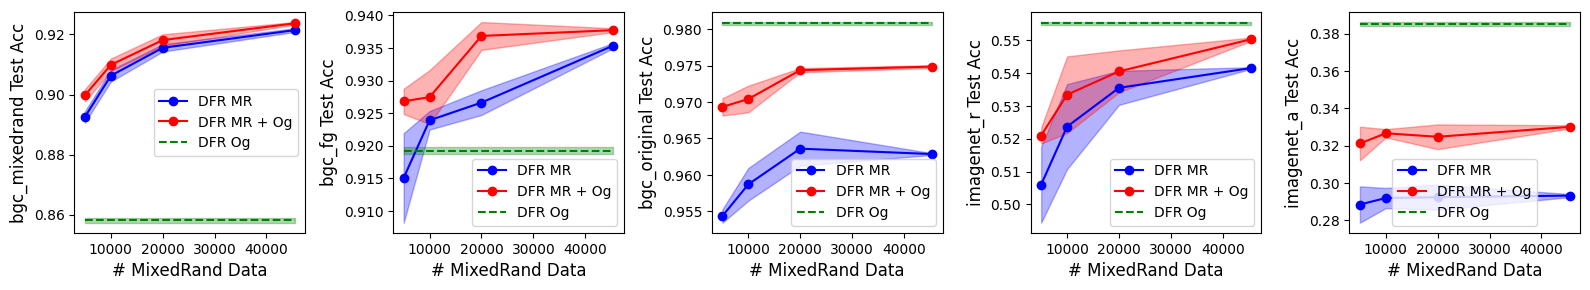

In [56]:
plot_all_results_indv(mixrand_results_ns_no, combo_results_ns_no, results_original_no)

## Pre Projection

In [57]:
use_ph = False

eval_path_dict = {
    "imagenet_r": f"/home/data/imagenet-r/Feb_imagenet-r_{use_ph}_val_standardSL_embeddings.npz",
    "imagenet_a": f"/home/data/imagenet-a/Feb_imagenet-a_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_original": f"/home/data/bg_challenge/original/Feb_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_fg": f"/home/data/bg_challenge/only_fg/Feb_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/data/bg_challenge/mixed_rand/Feb_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    "bgc_original": f"/home/data/original/Feb_bg_challenge_{use_ph}_train_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/data/mixed_rand/Feb_bg_challenge_{use_ph}_train_standardSL_embeddings.npz",
}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [58]:
_, results_original_pre = run_experiment(train_datasets, eval_datasets,
                                                num_mixrand=0, num_original=-1, lr=learning_rate, num_seeds=num_seeds, n_epochs=num_epochs,
                                                weight_decay=100/45405)

print_results(results_original_pre)

1
0.0022024006166721727
1000


-------------------
imagenet_r: 0.505±0.000
imagenet_a: 0.359±0.001
bgc_original: 0.984±0.000
bgc_fg: 0.908±0.001
bgc_mixedrand: 0.866±0.000
train: 0.998±0.000
-------------------


In [59]:

mixrand_results_ns_pre = mixrand_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)
combo_results_ns_pre = combo_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)

1
0.02
1000
-------------------
imagenet_r: 0.504±0.009
imagenet_a: 0.285±0.006
bgc_original: 0.964±0.002
bgc_fg: 0.923±0.002
bgc_mixedrand: 0.899±0.002
train: 0.995±0.001
-------------------
1
0.01
1000
-------------------
imagenet_r: 0.516±0.008
imagenet_a: 0.280±0.009
bgc_original: 0.963±0.003
bgc_fg: 0.926±0.004
bgc_mixedrand: 0.907±0.002
train: 0.985±0.001
-------------------
1
0.005
1000
-------------------
imagenet_r: 0.516±0.007
imagenet_a: 0.280±0.006
bgc_original: 0.962±0.001
bgc_fg: 0.931±0.004
bgc_mixedrand: 0.913±0.001
train: 0.962±0.001
-------------------
1
0.0022024006166721727
1000
-------------------
imagenet_r: 0.522±0.001
imagenet_a: 0.280±0.001
bgc_original: 0.964±0.000
bgc_fg: 0.936±0.000
bgc_mixedrand: 0.919±0.000
train: 0.925±0.000
-------------------
1
0.01
1000
-------------------
imagenet_r: 0.516±0.010
imagenet_a: 0.305±0.007
bgc_original: 0.977±0.002
bgc_fg: 0.928±0.003
bgc_mixedrand: 0.902±0.001
train: 0.992±0.001
-------------------
1
0.005
1000
---------

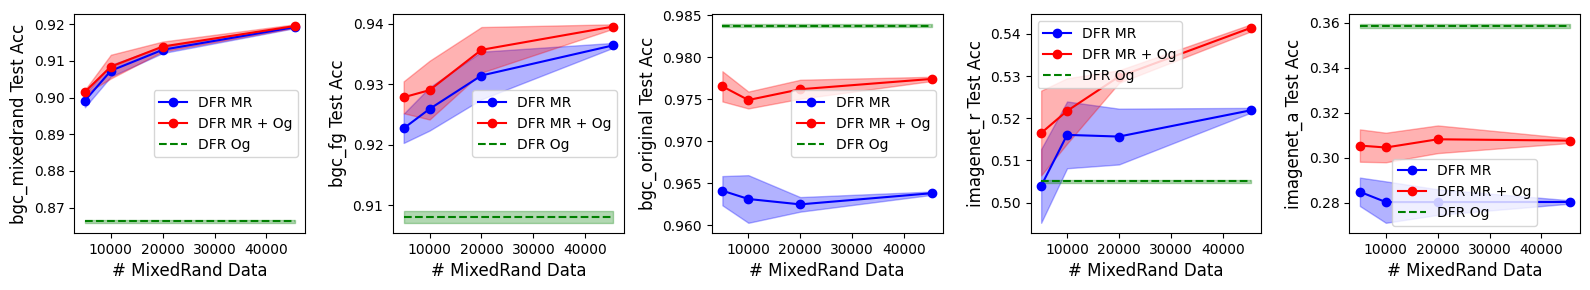

In [60]:
plot_all_results_indv(mixrand_results_ns_pre, combo_results_ns_pre, results_original_pre)

## Post Projection

In [61]:
use_ph = True

eval_path_dict = {
    "imagenet_r": f"/home/data/imagenet-r/Feb_imagenet-r_{use_ph}_val_standardSL_embeddings.npz",
    "imagenet_a": f"/home/data/imagenet-a/Feb_imagenet-a_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_original": f"/home/data/bg_challenge/original/Feb_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_fg": f"/home/data/bg_challenge/only_fg/Feb_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/data/bg_challenge/mixed_rand/Feb_bg_challenge_{use_ph}_val_standardSL_embeddings.npz",
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    "bgc_original": f"/home/data/original/Feb_bg_challenge_{use_ph}_train_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/data/mixed_rand/Feb_bg_challenge_{use_ph}_train_standardSL_embeddings.npz",
}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [62]:
_, results_original_post = run_experiment(train_datasets, eval_datasets,
                                                num_mixrand=0, num_original=-1, lr=learning_rate, num_seeds=num_seeds, n_epochs=num_epochs,
                                                weight_decay=100/45405)

print_results(results_original_post)

1
0.0022024006166721727
1000
-------------------
imagenet_r: 0.499±0.000
imagenet_a: 0.351±0.000
bgc_original: 0.982±0.000
bgc_fg: 0.909±0.000
bgc_mixedrand: 0.855±0.000
train: 0.992±0.000
-------------------


In [63]:

mixrand_results_ns_post = mixrand_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)
combo_results_ns_post = combo_run(ns, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)

1
0.02
1000
-------------------
imagenet_r: 0.493±0.005
imagenet_a: 0.287±0.006
bgc_original: 0.962±0.002
bgc_fg: 0.917±0.004
bgc_mixedrand: 0.888±0.003
train: 0.914±0.001
-------------------
1
0.01
1000
-------------------
imagenet_r: 0.508±0.005
imagenet_a: 0.291±0.005
bgc_original: 0.965±0.002
bgc_fg: 0.923±0.006
bgc_mixedrand: 0.896±0.002
train: 0.890±0.004
-------------------
1
0.005
1000
-------------------
imagenet_r: 0.509±0.006
imagenet_a: 0.278±0.005
bgc_original: 0.965±0.002
bgc_fg: 0.928±0.004
bgc_mixedrand: 0.903±0.004
train: 0.875±0.001
-------------------
1
0.0022024006166721727
1000
-------------------
imagenet_r: 0.515±0.000
imagenet_a: 0.275±0.000
bgc_original: 0.967±0.000
bgc_fg: 0.933±0.000
bgc_mixedrand: 0.908±0.000
train: 0.862±0.000
-------------------
1
0.01
1000
-------------------
imagenet_r: 0.506±0.006
imagenet_a: 0.303±0.005
bgc_original: 0.974±0.001
bgc_fg: 0.922±0.005
bgc_mixedrand: 0.891±0.001
train: 0.943±0.002
-------------------
1
0.005
1000
---------

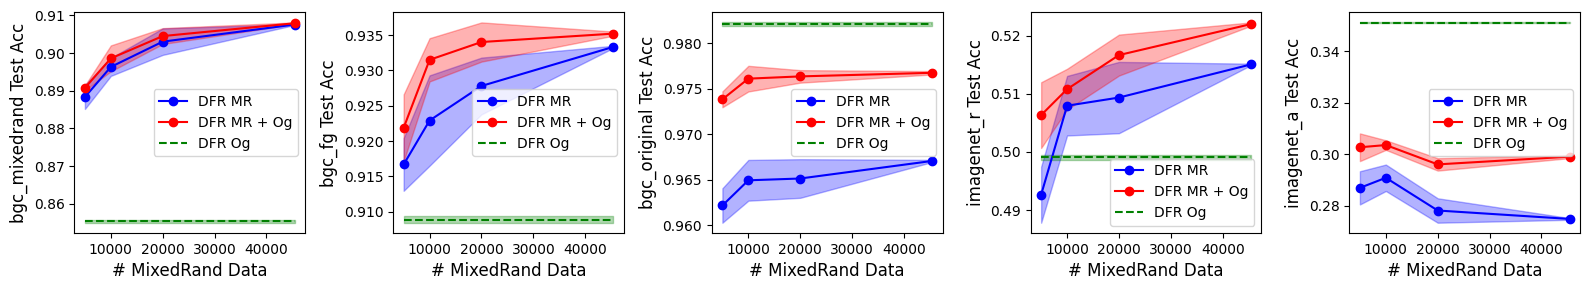

In [64]:
plot_all_results_indv(mixrand_results_ns_post, combo_results_ns_post, results_original_post)

## Out of Distribution Accuracy vs In Distribution Accuracy 

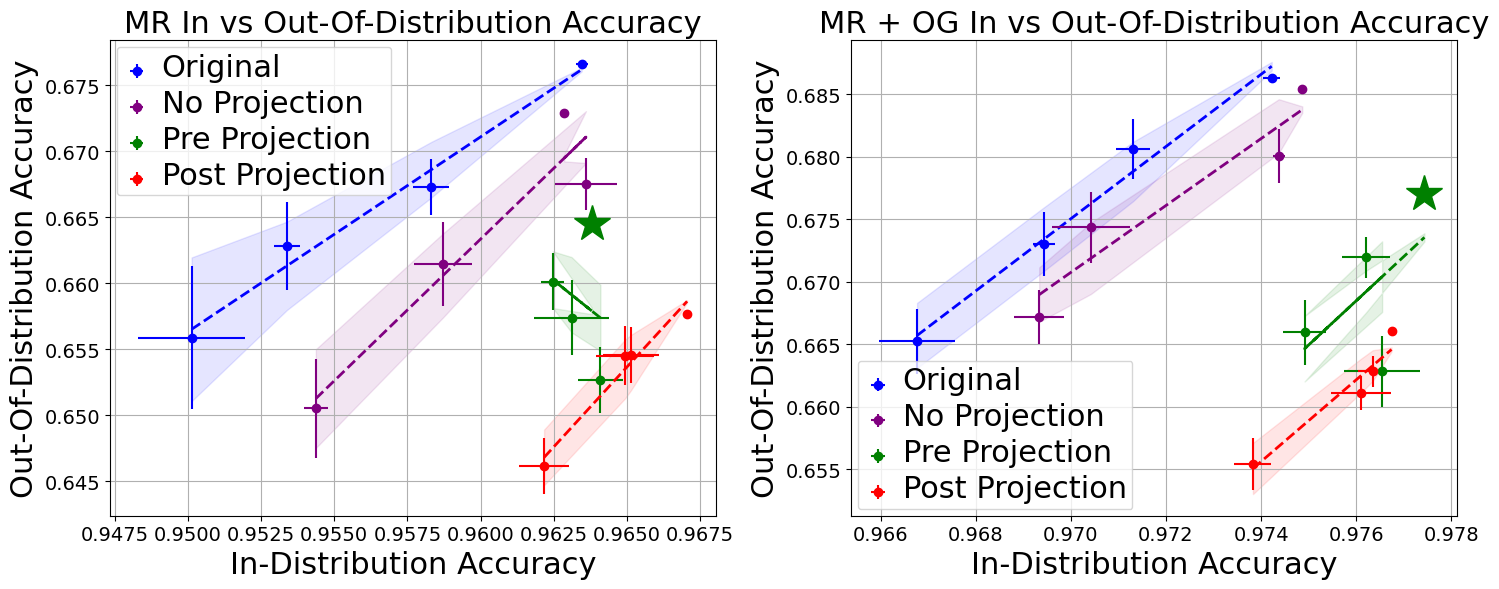

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def set_large_fonts(ax):
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.title.set_fontsize(22)
    ax.xaxis.label.set_fontsize(22)
    ax.yaxis.label.set_fontsize(22)
    for item in ax.get_legend().get_texts():
        item.set_fontsize(22)

def process_results(results):
    in_distrib_acc = []
    out_distrib_acc = []
    in_distrib_std = []
    out_distrib_std = []
    
    for res in results:
        in_distrib_acc.append(res['bgc_original'][0])
        in_distrib_std.append(res['bgc_original'][1])
        
        # out_distrib_means = [v[0] for k, v in res.items() if k != 'bgc_original' and k != 'train' and k != 'imagenet_a']
        # out_distrib_stds = [v[1] for k, v in res.items() if k != 'bgc_original' and k != 'train' and k != 'imagenet_a']
        out_distrib_means = [v[0] for k, v in res.items() if k != 'bgc_original' and k != 'train']
        out_distrib_stds = [v[1] for k, v in res.items() if k != 'bgc_original' and k != 'train']
        
        out_distrib_acc.append(np.mean(out_distrib_means))
        out_distrib_std.append(np.sqrt(np.mean(np.array(out_distrib_stds) ** 2)))  # Pooled standard deviation
        
    return in_distrib_acc, out_distrib_acc, in_distrib_std, out_distrib_std


def plot_results(in_acc, out_acc, in_std, out_std, label, color, n=5, ax=None, add_star=False):
    in_err = np.array(in_std) / np.sqrt(n)
    out_err = np.array(out_std) / np.sqrt(n)

    if ax is None:
        ax = plt.gca() 

    ax.errorbar(in_acc, out_acc, xerr=in_err, yerr=out_err, fmt='o', label=label, color=color)
    slope, intercept, _, _, _ = stats.linregress(in_acc, out_acc)
    in_acc_line = np.array(in_acc)
    out_acc_line = slope * in_acc_line + intercept

    ax.plot(in_acc_line, out_acc_line, '--', lw=2, color=color)
    ax.fill_between(in_acc_line, out_acc_line - out_err, out_acc_line + out_err, alpha=0.1, color=color)

    if add_star:
        highest_point_index = np.argmax(out_acc)
        ax.plot(in_acc[highest_point_index], out_acc[highest_point_index], marker='*', markersize=27, color='green')

fig, axs = plt.subplots(1, 2, figsize=(15, 6))  

in_original, out_original, in_std_original, out_std_original = process_results(mixrand_results_ns_ori)
in_no, out_no, in_std_no, out_std_no = process_results(mixrand_results_ns_no)
in_pre, out_pre, in_std_pre, out_std_pre = process_results(mixrand_results_ns_pre)
in_post, out_post, in_std_post, out_std_post = process_results(mixrand_results_ns_post)
axs[0].set_title('MR In vs Out-Of-Distribution Accuracy')
plot_results(in_original, out_original, in_std_original, out_std_original, 'Original', 'blue', ax=axs[0])
plot_results(in_no, out_no, in_std_no, out_std_no, 'No Projection', 'purple', ax=axs[0])
plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre Projection', 'green', ax=axs[0], add_star=True)
plot_results(in_post, out_post, in_std_post, out_std_post, 'Post Projection', 'red', ax=axs[0])


in_original, out_original, in_std_original, out_std_original = process_results(combo_results_ns_ori)
in_no, out_no, in_std_no, out_std_no = process_results(combo_results_ns_no)
in_pre, out_pre, in_std_pre, out_std_pre = process_results(combo_results_ns_pre)
in_post, out_post, in_std_post, out_std_post = process_results(combo_results_ns_post)

axs[1].set_title('MR + OG In vs Out-Of-Distribution Accuracy')
plot_results(in_original, out_original, in_std_original, out_std_original, 'Original', 'blue', ax=axs[1])
plot_results(in_no, out_no, in_std_no, out_std_no, 'No Projection', 'purple', ax=axs[1])
plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre Projection', 'green', ax=axs[1], add_star=True)
plot_results(in_post, out_post, in_std_post, out_std_post, 'Post Projection', 'red', ax=axs[1])



for ax in axs:
    ax.set_xlabel('In-Distribution Accuracy')
    ax.set_ylabel('Out-Of-Distribution Accuracy')
    ax.legend()
    ax.grid(True)
    set_large_fonts(ax)

plt.tight_layout()
# plt.savefig('projection_head_linear_seval.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)


plt.show()

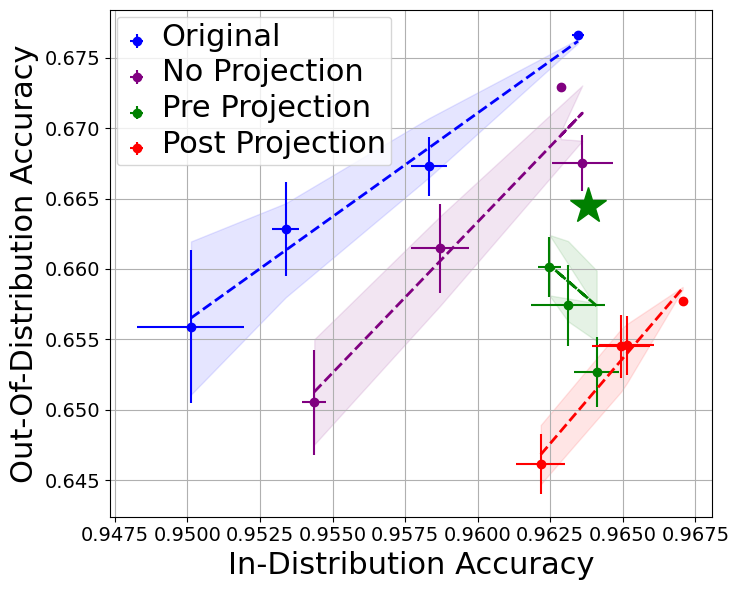

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def set_large_fonts(ax):
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.title.set_fontsize(22)
    ax.xaxis.label.set_fontsize(22)
    ax.yaxis.label.set_fontsize(22)
    for item in ax.get_legend().get_texts():
        item.set_fontsize(22)

def process_results(results):
    in_distrib_acc = []
    out_distrib_acc = []
    in_distrib_std = []
    out_distrib_std = []
    
    for res in results:
        in_distrib_acc.append(res['bgc_original'][0])
        in_distrib_std.append(res['bgc_original'][1])
        
        # out_distrib_means = [v[0] for k, v in res.items() if k != 'bgc_original' and k != 'train' and k != 'imagenet_a']
        # out_distrib_stds = [v[1] for k, v in res.items() if k != 'bgc_original' and k != 'train' and k != 'imagenet_a']
        out_distrib_means = [v[0] for k, v in res.items() if k != 'bgc_original' and k != 'train']
        out_distrib_stds = [v[1] for k, v in res.items() if k != 'bgc_original' and k != 'train']
        
        out_distrib_acc.append(np.mean(out_distrib_means))
        out_distrib_std.append(np.sqrt(np.mean(np.array(out_distrib_stds) ** 2)))  # Pooled standard deviation
        
    return in_distrib_acc, out_distrib_acc, in_distrib_std, out_distrib_std


def plot_results(in_acc, out_acc, in_std, out_std, label, color, n=5, ax=None, add_star=False):
    in_err = np.array(in_std) / np.sqrt(n)
    out_err = np.array(out_std) / np.sqrt(n)

    if ax is None:
        ax = plt.gca() 

    ax.errorbar(in_acc, out_acc, xerr=in_err, yerr=out_err, fmt='o', label=label, color=color)
    slope, intercept, _, _, _ = stats.linregress(in_acc, out_acc)
    in_acc_line = np.array(in_acc)
    out_acc_line = slope * in_acc_line + intercept

    ax.plot(in_acc_line, out_acc_line, '--', lw=2, color=color)
    ax.fill_between(in_acc_line, out_acc_line - out_err, out_acc_line + out_err, alpha=0.1, color=color)

    if add_star:
        highest_point_index = np.argmax(out_acc)
        ax.plot(in_acc[highest_point_index], out_acc[highest_point_index], marker='*', markersize=27, color='green')

fig, axs = plt.subplots(1, 1, figsize=(7.5, 6))  

in_original, out_original, in_std_original, out_std_original = process_results(mixrand_results_ns_ori)
in_no, out_no, in_std_no, out_std_no = process_results(mixrand_results_ns_no)
in_pre, out_pre, in_std_pre, out_std_pre = process_results(mixrand_results_ns_pre)
in_post, out_post, in_std_post, out_std_post = process_results(mixrand_results_ns_post)
plot_results(in_original, out_original, in_std_original, out_std_original, 'Original', 'blue', ax=axs)
plot_results(in_no, out_no, in_std_no, out_std_no, 'No Projection', 'purple', ax=axs)
plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre Projection', 'green', ax=axs, add_star=True)
plot_results(in_post, out_post, in_std_post, out_std_post, 'Post Projection', 'red', ax=axs)


# in_original, out_original, in_std_original, out_std_original = process_results(combo_results_ns_ori)
# in_no, out_no, in_std_no, out_std_no = process_results(combo_results_ns_no)
# in_pre, out_pre, in_std_pre, out_std_pre = process_results(combo_results_ns_pre)
# in_post, out_post, in_std_post, out_std_post = process_results(combo_results_ns_post)

# axs[1].set_title('MR + OG In vs Out-Of-Distribution Accuracy')
# plot_results(in_original, out_original, in_std_original, out_std_original, 'Original', 'blue', ax=axs[1])
# plot_results(in_no, out_no, in_std_no, out_std_no, 'No Projection', 'purple', ax=axs[1])
# plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre Projection', 'green', ax=axs[1], add_star=True)
# plot_results(in_post, out_post, in_std_post, out_std_post, 'Post Projection', 'red', ax=axs[1])



axs.set_xlabel('In-Distribution Accuracy')
axs.set_ylabel('Out-Of-Distribution Accuracy')
axs.legend()
axs.grid(True)
set_large_fonts(axs)

plt.tight_layout()
# plt.savefig('MR_projection_head_linear_eval.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)


plt.show()

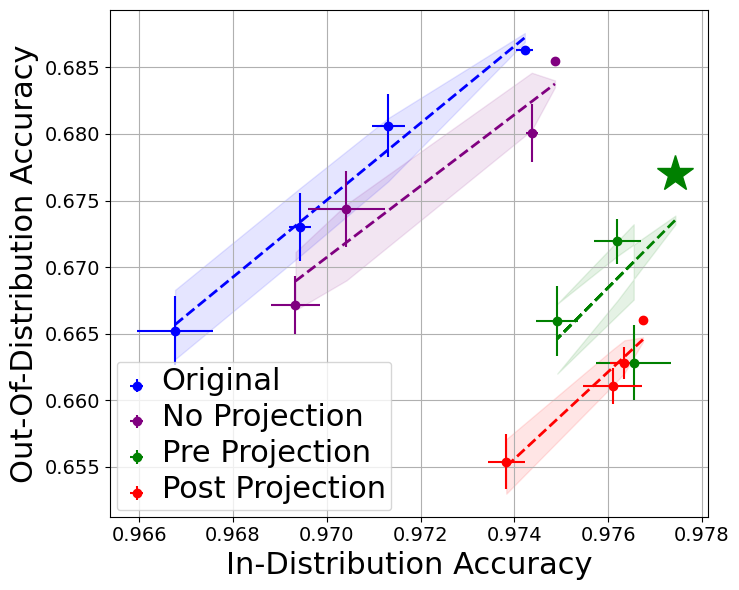

In [67]:
fig, axs = plt.subplots(1, 1, figsize=(7.5, 6))  


in_original, out_original, in_std_original, out_std_original = process_results(combo_results_ns_ori)
in_no, out_no, in_std_no, out_std_no = process_results(combo_results_ns_no)
in_pre, out_pre, in_std_pre, out_std_pre = process_results(combo_results_ns_pre)
in_post, out_post, in_std_post, out_std_post = process_results(combo_results_ns_post)

plot_results(in_original, out_original, in_std_original, out_std_original, 'Original', 'blue', ax=axs)
plot_results(in_no, out_no, in_std_no, out_std_no, 'No Projection', 'purple', ax=axs)
plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre Projection', 'green', ax=axs, add_star=True)
plot_results(in_post, out_post, in_std_post, out_std_post, 'Post Projection', 'red', ax=axs)


axs.set_xlabel('In-Distribution Accuracy')
axs.set_ylabel('Out-Of-Distribution Accuracy')
axs.legend()
axs.grid(True)
set_large_fonts(axs)

plt.tight_layout()
# plt.savefig('MROG_projection_head_linear_eval.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)


plt.show()



In [68]:
# file_path = "projection_head_original.txt"

# with open(file_path, "w") as file:
#     file.write("MR_results_ori:\n")
#     file.write(str(mixrand_results_ns_ori) + "\n\n")
    
#     file.write("MR_results_pre:\n")
#     file.write(str(mixrand_results_ns_pre) + "\n\n")
    
#     file.write("MR_results_post:\n")
#     file.write(str(mixrand_results_ns_post) + "\n\n")
    
#     file.write("MROG_results_ori:\n")
#     file.write(str(combo_results_ns_ori) + "\n\n")
    
#     file.write("MROG_results_pre:\n")
#     file.write(str(combo_results_ns_pre) + "\n\n")
    
#     file.write("MROG_results_post:\n")
#     file.write(str(combo_results_ns_post) + "\n\n")

# print(f"Results saved to {file_path}")